In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine,reflect=True)
# reflect the tables
insp = inspect(engine)
insp.get_table_names()

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# View all table columns for each table
meas_columns = insp.get_columns('measurement')
print("Measurement columns:")
for c in meas_columns:
    print(c['name'], c['type'])
    
stat_columns = insp.get_columns('station')
print("\nStation columns:")
for c in stat_columns:
    print(c['name'], c['type'])

Measurement columns:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station columns:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).limit(1).all()
recent_date

[('2017-08-23')]

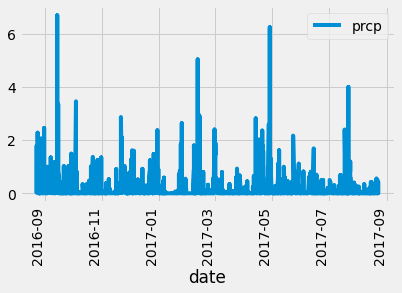

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.id,
       measurement.station,     
       measurement.date,
       measurement.prcp,
       measurement.tobs
      ]

past_year = session.query(*sel).filter(measurement.date >= query_date).all()

#Save the query results as a Pandas DataFrame and set the index to the date column
  
df = pd.DataFrame(past_year).drop(columns=["id","station","tobs"])
df['date'] = pd.to_datetime(df.date)
df = df.sort_values('date')
df = df.dropna(how='any')


# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date',y='prcp',rot=90)


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(station.station).all()
len(stations)

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
result = session.query(station.station,func.count(station.station)).filter(station.station==measurement.station).group_by(station.station).\
    order_by(func.count(station.station).desc()).all()
for r in result:
    print(r)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [
    func.avg(measurement.tobs),
    func.min(measurement.tobs),
    func.max(measurement.tobs)
]
result = session.query(*sel).filter(measurement.station=='USC00519281').all()
print(f'Station USC00519281\nAverage Temp: {round(result[0][0],2)}\nMin Temp: {result[0][1]}\nMax Temp: {result[0][2]} ')

Station USC00519281
Average Temp: 71.66
Min Temp: 54.0
Max Temp: 85.0 


Text(0, 0.5, 'Frequency')

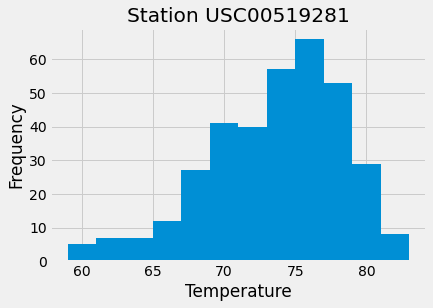

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_year_temps = session.query(measurement.tobs).filter(measurement.date >= query_date).\
    filter(measurement.station=='USC00519281').all()
temps = [result[0] for result in past_year_temps]

plt.hist(temps,bins=12)
plt.title("Station USC00519281")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Close session

In [17]:
# Close Session
session.close()